In [3]:
print("Hello bye");
row=list();
ft=open("train.csv");
data=ft.read();
print(data);

Hello bye
ID,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.9557700000000001,0.0,8.14,0,0.538,6.047,88.8,4.4534,4,307.0,21.0,306.38,17.28,14.8
1,0.02875,28.0,15.04,0,0.464,6.211,28.9,3.6659,4,270.0,18.2,396.33,6.21,25.0
2,1.22358,0.0,19.58,0,0.605,6.943,97.4,1.8773,5,403.0,14.7,363.43,4.59,41.3
3,5.66637,0.0,18.1,0,0.74,6.219,100.0,2.0048,24,666.0,20.2,395.69,16.59,18.4
4,0.045439999999999994,0.0,3.24,0,0.46,6.144,32.2,5.8736,4,430.0,16.9,368.57,9.09,19.8
5,0.10659,80.0,1.91,0,0.413,5.936,19.5,10.5857,4,334.0,22.0,376.04,5.57,20.6
6,51.1358,0.0,18.1,0,0.597,5.757,100.0,1.413,24,666.0,20.2,2.6,10.11,15.0
7,3.32105,0.0,19.58,1,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.9,26.82,13.4
8,1.05393,0.0,8.14,0,0.538,5.935,29.3,4.4986,4,307.0,21.0,386.85,6.58,23.1
9,0.24522,0.0,9.9,0,0.544,5.782,71.7,4.0317,4,304.0,18.4,396.9,15.94,19.8
10,0.57834,20.0,3.97,0,0.575,8.297,67.0,2.4216,5,264.0,13.0,384.54,7.44,50.0
11,0.03537,34.0,6.09,0,0.433,6.59,40.4,5.4917,7,329.0,16.1,395.75,

In [10]:
import numpy as np;
from numpy.linalg import inv;
from numpy.linalg import det;
import math;

trainDSSizePercentage=0.7; # x*100 percentage. 1-x data set will be used for validating

# Will read the file and convert it into two dataset one train data other validate data
def readTrainData(fileName):
    row_index=0;
    phi=list();
    y=list();
    with open(fileName) as f:
        for line in f:
            if row_index >0:
                phi_i=list((float(n) for n in line.split('\n')[0].split(",") ));
                phi_i[0]=1;            
                # last row is value of yi                
                y_i=phi_i.pop(len(phi_i)-1); 
                phi.append(phi_i);             
                y.append(y_i);
            row_index+=1;
    return [phi,y];
#End-readTrainData

# Will read the file and convert it into dataset for Testing the Model
def readTestData(fileName):
    row_index=0;
    phi=list();
    y=list();
    with open(fileName) as f:
        for line in f:
            if row_index >0:
                phi_i=list((float(n) for n in line.split('\n')[0].split(",") ));
                phi_i[0]=1;
                phi.append(phi_i);                             
            row_index+=1;
    m=len(phi);    
    return phi;
#End-readTrainData


#split train data into Train and Validate
def spitTrainDataset(phi,y):
    m=len(phi);        
    tdsSize=int(m*trainDSSizePercentage);
    
    trainDatasetPhi=phi[0:tdsSize];
    trainDatasetY=y[0:tdsSize];
    validateDatasetPhi=phi[tdsSize:m];
    validateDatasetY=y[tdsSize:m];    
   
    return [trainDatasetPhi,trainDatasetY,validateDatasetPhi,validateDatasetY];    
    pass


#write-output
def writeTestData(ystar):
    fo = open("output.csv", "w");    
    fo.write("ID,MEDV\n");
    m=len(ystar);
    for i in range(m):
        fo.write(str(i)+","+str(ystar[i])+"\n");
    fo.close();
    pass;

# Return det of matrix
def getDet(A):
    d=det(A);
    if(d<10**-10):
        return 0;
    return d;


#Return RMS: root mean square error
def getRMS(y,yStar):
    m=len(y);
    sigma=0;
    for i in range(m):
        delta=(y[i]-yStar[i]);
        delta=delta*delta;
        sigma=sigma+delta;
    meanSq=sigma/m;   
    rms=math.sqrt(meanSq);
    return rms;
    pass;

#For ploting graph of RMS VS Iteration
def plotGraph(x,y):
    import matplotlib.pyplot as plt;
    plt.plot(x,y)
    plt.ylabel('rms')
    plt.xlabel('iteration');
    plt.show();
    pass;

#Record readings for gradient descent
def writeReadingInFile(filename,alpha,lam,iteration,rms,p):
    import os.path;
    import datetime;
    import time;
    ts = datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m-%Y %H:%M:%S')
    if(os.path.exists(filename)==False):
        fo = open(filename, "w"); 
        fo.write("iteration,norm,alpha,lam,rms,timestamp\n");
        fo.write(str(iteration)+","+str(p)+","+str(alpha)+","+str(lam)+","+str(rms)+","+str(ts)+"\n");
    else:
        fo = open(filename, "a"); 
        fo.write(str(iteration)+","+str(p)+","+str(alpha)+","+str(lam)+","+str(rms)+","+str(ts)+"\n");
    fo.close();                    
    pass;


#normalize the data set ny (x-u)/s where s is max-min
def normalizePhi(unNormalizedPhi):    
    phi=np.array(unNormalizedPhi);
    print("Normalizing Phi...");  
    std=phi.std(0);
    mean=phi.mean(0);    
    std[0]=1;
    mean[0]=0;
    phi_normalize=(phi-mean)/std;    
    print("Normalization done.");
    return phi_normalize;
    pass;

#pridict of y* given w* QW=y*
def pridict(dataset,weight):
    phi=np.array(dataset);
    w=np.array(weight);
    ystar=np.dot(phi,w);
    return ystar;
    pass;

# Finding w*=(QTQ)^-1QTY
def trainUsingClosedFormEquation(dataset,output):
    m=len(dataset);
    n=len(dataset[0]);
    print("------------------");
    #print(dataset);
    phi=np.array(dataset);
    print("------------------");
    #print(phi);    
    y=np.array(output);
    phiT=np.transpose(phi);
    #(QTQ)    
    phiT_phi=np.dot(phiT,phi);   
    d=getDet(phiT_phi)
    if(d>0):
        #(QTQ)^-1
        phiT_phi_inv=inv(phiT_phi);
        #(QTQ)^-1QT
        phiT_phi_inv_phiT=np.dot(phiT_phi_inv,phiT);  
        #(QTQ)^-1QT*Y
        w=np.dot(phiT_phi_inv_phiT,y);
        return w;
    else:
        print("Error:Phi is NOT full column rank.");
        return None;
    pass;

# Finding w*=(QTQ+lamI)^-1QTY
def trainUsingClosedFormRidgeEq(dataset,output):
    m=len(dataset);
    n=len(dataset[0]);    
    phi=np.array(dataset);
    y=np.array(output);
    phiT=np.transpose(phi);    
    #(QTQ)    
    phiT_phi=np.dot(phiT,phi);
    n=len(phiT_phi);
    lam=0.3;
    I=np.identity(n);
    lamI=lam*I;
    d=getDet(phiT_phi)
    #--------------------------------------
    if(d>0):
        #(QTQ+lamI)^-1
        phiT_phi_inv=inv((phiT_phi+lamI));
        #(QTQ+lamI)^-1QT
        phiT_phi_inv_phiT=np.dot(phiT_phi_inv,phiT);  
        #(QTQ+lamI)^-1QT*Y
        w=np.dot(phiT_phi_inv_phiT,y);
        return w;
    else:
        print("Error:Phi is NOT full column rank.");
        return None;
    pass;


def numpiTestFun():
    A2= np.matrix([[4,6],[2,8]])        
    A3= np.matrix([[1,2,3],[4,5,7],[7,8,9]])
    A=A2;
    print(A);
    print(np.power(A,0.5));
    print(A);
    print("Det(A):"+str(getDet(A)));
    B= np.transpose(A);
    C=inv(A);
    #print(C);
    print(np.dot(A,C));
    print(A.std(0));
    print(A.mean(0));
    print(normalizePhi(A));
    norm=(A-A.mean(0))/A.std(0);    
    print(norm);    
    print();
    pass;

def mainClosedFormSol():

    #--------------------[Closed Form Sol without Regularlization]--------------------------------
    #Find w*
    wStar=trainUsingClosedFormEquation(trainDatasetPhi,trainDatasetY);
    #Predict y* for Validate Data
    ystar=pridict(validateDatasetPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(validateDatasetY,ystar);
    #Predict y* for TestData
    ystar=pridict(testDS_norm,wStar);
    writeTestData(ystar);
    print("ClosedFormSolWithoutReg RMS:",rms);
    #---------------------------------------------------------------------------------------------
    pass;



def mainRidgeClosedFormSol():

    #--------------------[Closed Form Sol without Regularlization]--------------------------------
    #Find w*
    wStar=trainUsingClosedFormRidgeEq(trainDatasetPhi,trainDatasetY);
    #Predict y* for Validate Data
    ystar=pridict(validateDatasetPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(validateDatasetY,ystar);
    #Predict y* for TestData
    ystar=pridict(testDS_norm,wStar);
    writeTestData(ystar);
    print("ClosedFormSolWithoutReg RMS:",rms);
    #---------------------------------------------------------------------------------------------
    pass;


Training Started (Least Sq. With Ridge) ...
# iteration:  0  rms: 18.300505853995087 diff: -18.300505853995087  vrms: 18.57224709858816  vdiff: -18.57224709858816
# iteration:  100  rms: 4.478192210693016 diff: 0.00010328222359667905  vrms: 5.082839595194634  vdiff: 0.0003009073562898479
# iteration:  200  rms: 4.47439694452587 diff: 9.542704876075447e-06  vrms: 5.071427142131347  vdiff: 3.3174289601589635e-05
# iteration:  300  rms: 4.474010869830965 diff: 1.1845275054156446e-06  vrms: 5.0698581986694  vdiff: 6.532232648126524e-06
# iteration:  400  rms: 4.473956390760812 diff: 2.124150357829535e-07  vrms: 5.069506653154401  vdiff: 1.6888225466971107e-06
# iteration:  500  rms: 4.473945382867875 diff: 5.047052820117415e-08  vrms: 5.06941209178239  vdiff: 4.7195917574072155e-07
# iteration:  600  rms: 4.473942604368808 diff: 1.3621545669195712e-08  vrms: 5.069385396684585  vdiff: 1.34517391892075e-07
# iteration:  700  rms: 4.473941838271005 diff: 3.838378503928652e-09  vrms: 5.0693777

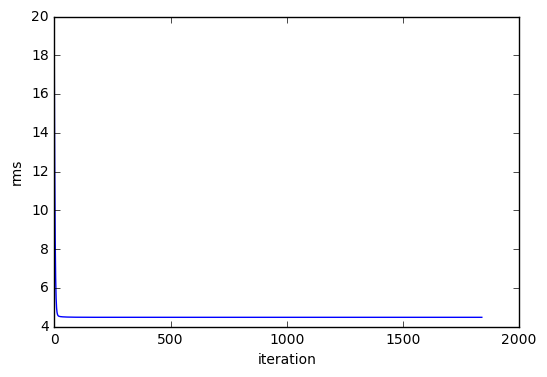

In [12]:
# GD: Least Sq. Without Regularlization
def gardientDescentErrorFun(phi,y):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.22;# learning parameter
    maxIteration=10000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    xaxis=list();
    yaxis=list();
    #----------------------
    print("Training Started (Least Sq. Without Regularlization) ...");
    for i in range(maxIteration):  
        wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)));                
        ystar=pridict(phi,wk1);
        rms=getRMS(y,ystar);    
        xaxis.append(i);
        yaxis.append(rms);
        percentComplete=((i+1)*100)/maxIteration;
        if( percentComplete%10==0 ):
            print("Percent Completed",percentComplete);
        wk0=wk1;
    print("Final Trained RMS:",rms);
    plotGraph(xaxis,yaxis);
    return wk1;
    pass;


 

# GD: Least Sq. With Ridges
def gardientDescentWithRidge(phi,y):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.212;# learning parameter
    maxIteration=10000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector
    #wk0=phi[14];#14
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    lam=0.301;    
    xaxis=list();
    yaxis=list();
    algFixedIteration=False;
    logReading=True;
    diff=0;
    #-----------------------------------------------------------------
    #Best Tested Constant
    #aplha=.212 lamda=.301 datasie=0.7 o/p=4.8310 rms
    #Tried for different initial wk0 but o/p remain same
    #-----------------------------------------------------------------
    print("Training Started (Least Sq. With Ridge) ...");
    if (algFixedIteration):
        for iteration in range(0,maxIteration):  
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0)));                   
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            percentComplete=((iteration+1)*100)/maxIteration;
            if( percentComplete%10==0 ):
                print("Percent Completed",percentComplete);
            wk0=wk1;
    else:
        diffOffset=1e-20;
        iteration=0;
        oldRms=0;
        voldRms=0;
        while (True):
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0)));                     
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            diff=oldRms-rms;
            
            vystar=pridict(validateDatasetPhi,wk1);
            vrms=getRMS(validateDatasetY,vystar);
            vdiff=voldRms-vrms;
            
            if(iteration>0 and diff<diffOffset):
                break;
            if(False and iteration%100==0 ):
                print("# iteration: ",iteration," rms:",rms,"diff:",diff," vrms:",vrms," vdiff:", vdiff);            
            wk0=wk1;
            oldRms=rms;
            voldRms=vrms;
            iteration+=1;
        print("# iteration: ",iteration," rms:",rms,"diff:",diff," vrms:",vrms," vdiff:", vdiff);    
           
    print("Final Trained RMS:",rms ,". Iteration needed ", iteration);    
    #-------------------------------------------------------------
    if(logReading):
        writeReadingInFile("ridge.csv",alpha,lam,iteration,rms,2);
    plotGraph(xaxis,yaxis);
    return wk1;

# GD: Least Sq. With ||w||_(1.5)^(1.5)
def gardientDescentWithPnom(phi,y,p):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.2 #learning parameter
    maxIteration=100000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector    
    wk0=phi[1];
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    lam=0.31;
    xaxis=list();
    yaxis=list();
    algFixedIteration=False;
    logReading=True;
    diff=0;
    wPow=p-1;
    if (p<=1):
        print("Error: norm p is less than 1 i.p p=",wPow);
        return None;
        
    #-----------------------------------------------------------------
    print("Training Started (Least Sq. With Ridge) ...");
    if (algFixedIteration):
        for iteration in range(0,maxIteration):
            if (wPow>1):
                wk0Pow=np.power(wk0,wPow);            
            else:
                wk0Pow=wk0;
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0Pow))); 
            
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            percentComplete=((iteration+1)*100)/maxIteration;
            if( percentComplete%10==0 ):
                print("Percent Completed",percentComplete);
            wk0=wk1;
    else:
        diffOffset=1e-20;
        iteration=0;
        oldRms=0;
        voldRms=0;
        while (True):            
            if (wPow>1):
                wk0Pow=np.power(wk0,wPow);            
            else:
                wk0Pow=wk0;
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0Pow)));  
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            diff=oldRms-rms;
            
            vystar=pridict(validateDatasetPhi,wk1);
            vrms=getRMS(validateDatasetY,vystar);
            vdiff=voldRms-vrms;
            
            if(iteration>0 and  diff<=diffOffset):
                break;
            if(False and iteration%100==0 ):
                print("# iteration: ",iteration," rms:",rms,"diff:",diff," vrms:",vrms," vdiff:", vdiff);            
            wk0=wk1;
            oldRms=rms;
            voldRms=vrms;
            iteration+=1;
        print("# iteration: ",iteration," rms:",rms,"diff:",diff," vrms:",vrms," vdiff:", vdiff);    

    print("Final Trained RMS:",rms ,". Iteration needed ", iteration);       
    #-------------------------------------------------------------
    if(logReading):
        writeReadingInFile("pnom.csv",alpha,lam,iteration,rms,p);
    plotGraph(xaxis,yaxis);
    return wk1; 

#wStart=gardientDescentWithRidge(trainDatasetPhi,trainDatasetY);
wStart=gardientDescentWithPnom(trainDatasetPhi,trainDatasetY,(4/3));


Fetching Trained Dataset from file...
Normalizing Phi...
Normalization done.
Normalizing Phi...
Normalization done.
Fetching of data Completed.
Train Size:280
Validate Size:120
Training Started (Least Sq. With Ridge) ...
# iteration:  1738  rms: 4.473935918164752 diff: 0.0  vrms: 5.069317392885473  vdiff: 3.019806626980426e-14
Final Trained RMS: 4.473935918164752 . Iteration needed  1738


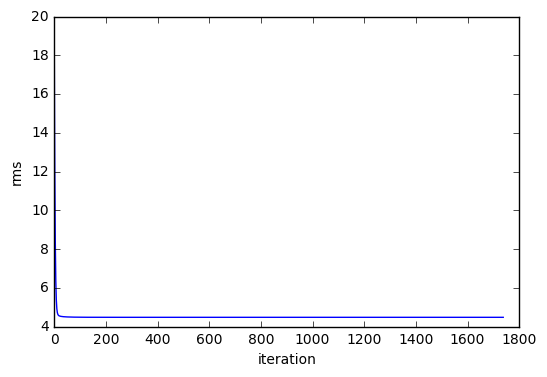

ClosedFormSolWithReg RMS: 5.069317392885473


In [11]:
#--settings--
np.set_printoptions(suppress=True)
#---init---
dir=""
trainFile=dir+"train.csv";
testFile=dir+"test.csv";
print("Fetching Trained Dataset from file...");
dataset=readTrainData(trainFile);
phiSet=dataset[0];
ySet=dataset[1];
phiSet_norm=normalizePhi(phiSet);
dataset=spitTrainDataset(phiSet_norm,ySet);
testDS=readTestData(testFile);
testDS_norm=normalizePhi(testDS);
print("Fetching of data Completed.");

#train set
trainDatasetPhi=dataset[0];
trainDatasetY=dataset[1];
#validate set
validateDatasetPhi=dataset[2];
validateDatasetY=dataset[3];
#print(testDS);
#print(testDS_norm);
print("Train Size:"+str(len(trainDatasetPhi)));
print("Validate Size:"+str(len(validateDatasetPhi)));
#numpiTestFun();

#mainClosedFormSol();
#mainRidgeClosedFormSol();
#--------------------[Gradient decent without Regularlization]--------------------------------
wStar=gardientDescentWithRidge(trainDatasetPhi,trainDatasetY);
#wStar=gardientDescentWithPnom(trainDatasetPhi,trainDatasetY,(4/3));
#Predict y* for Validate Data
ystar=pridict(validateDatasetPhi,wStar);
#checking for RMS for Validate Data
rms=getRMS(validateDatasetY,ystar);
#Predict y* for TestData
#ystar=pridict(testDS_norm,wStar);
#writeTestData(ystar);
print("ClosedFormSolWithReg RMS:",rms);
#---------------------------------------------------------------------------------------------
